In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import re

**Load Dataset**

In [2]:
import plotly as px
df = px.data.tips()

In [ ]:
# Check data strcuture
df

,total_bill,tip,sex,smoker,day,time,size
0,16.99,1.01,Female,No,Sun,Dinner,2
1,10.34,1.66,Male,No,Sun,Dinner,3
2,21.01,3.50,Male,No,Sun,Dinner,3
3,23.68,3.31,Male,No,Sun,Dinner,2
4,24.59,3.61,Female,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
239,29.03,5.92,Male,No,Sat,Dinner,3
240,27.18,2.00,Female,Yes,Sat,Dinner,2
241,22.67,2.00,Male,Yes,Sat,Dinner,2
242,17.82,1.75,Male,No,Sat,Dinner,2


**Data Fiiting**

In [3]:
# Set layers to draw
data_syn = pd.DataFrame([], columns = ['rank_1', 'rank_2', 'rank_3', 'rank_4', 'rank_5', 'value'])

# Set each layer with category's name
data_syn['rank_2'] = df['sex']
data_syn['rank_3'] = df['smoker']
data_syn['rank_4'] = df['day']
data_syn['rank_5'] = df['time']

# Begin with 'all'
data_syn['rank_1'] = 'All'
data_syn['value'] = df['total_bill']

data_syn.sort_values(['rank_2', 'rank_3', 'rank_4', 'rank_5'], inplace=True)
data_syn = data_syn.reset_index()

In [ ]:
# data that RIT use for plotting
data_syn

,index,rank_1,rank_2,rank_3,rank_4,rank_5,value
0,94,All,Female,No,Fri,Dinner,22.75
1,223,All,Female,No,Fri,Lunch,15.98
2,21,All,Female,No,Sat,Dinner,20.29
3,22,All,Female,No,Sat,Dinner,15.77
4,29,All,Female,No,Sat,Dinner,19.65
...,...,...,...,...,...,...,...
239,194,All,Male,Yes,Thur,Lunch,16.58
240,196,All,Male,Yes,Thur,Lunch,10.34
241,199,All,Male,Yes,Thur,Lunch,13.51
242,200,All,Male,Yes,Thur,Lunch,18.71


**Hyper-Parameter of the RIT**

In [4]:
# circle rate
c = 1.0
# level 0 donut starting radius
R0 = 0  *  c
# level 0 donut starting height
H0 = 4 *  c
# percentage of the angle ratio (wedge over a-section) < 0.5
AR = 0.1
alfa = AR/2
# topup additional
cut_ex = 0.05
# full circle length (change if do not want a full circle)
c_all = 2 * np.pi

Set the colors and the category here.

In [5]:
name_replace = ['Male', 'Female', 'Yes', 'No', 'Thur', 'Fri', 'Sat', 'Sun', 'Dinner', 'Lunch']
color4replace = ['#8dd3c7','#dfc27d','#bebada','#fb8072','#80b1d3','#fdb462','#b3de69','#fccde5','#d9d9d9','#bc80bd']
name_color_dict = dict(zip(name_replace, color4replace))

**Data Fitting**

In [6]:
def data_preprocess(data_syn, name_replace, colorbars):
  total_weight = data_syn['value'].sum()
  data_syn['percentage'] = data_syn['value'] / total_weight

  data_syn['color_2'] = data_syn['rank_2']
  data_syn['color_2'].replace(name_replace, colorbars , inplace=True)
  data_syn['color_3'] = data_syn['rank_3']
  data_syn['color_3'].replace(name_replace, colorbars , inplace=True)
  data_syn['color_4'] = data_syn['rank_4']
  data_syn['color_4'].replace(name_replace, colorbars , inplace=True)
  data_syn['color_5'] = data_syn['rank_5']
  data_syn['color_5'].replace(name_replace, colorbars , inplace=True)
# set more colors if needed

  data_syn['location_2'] = data_syn['percentage'].cumsum() * 2 * np.pi * c
  data_syn['location_2'] = data_syn['location_2'].shift(1)

  data_syn.at[0, 'location_2'] = 0
  return data_syn

data_syn = data_preprocess(data_syn, name_replace, color4replace)

**Essential Functions**

In [7]:
def calculate_wedge_area(H, R):
  area = np.pi * ((H+R) * (H+R) - R*R)
  return area

def calculate_normalised_height(new_r, std_area):
    norm_h = 0.5*(-2 * new_r + math.sqrt(4* new_r * new_r + 4* std_area/np.pi))
    return norm_h

def calculate_topup_height(alfa, beta, R, r):
  alpha_h = beta * alfa
  S_chord = 0.5 * R * R * (alpha_h - math.sin(alpha_h))
  S_BAC = 0.5 * (R * R * math.sin(alpha_h) - 2 * R * r * math.sin(alpha_h/2))
  D = (S_chord + S_BAC)/(beta - alpha_h)
  wedge_h = 0.5 * (-2 * R +  math.sqrt((2 * R) * (2 * R) + 4 * D))
  return wedge_h

def remove_wedge_start(cut_d, location, bottom, new_r):
  loca = location
  theta1 = np.array([loca, loca, loca + cut_d])
  r1 = np.array([bottom, new_r + cut_ex, new_r + cut_ex])
  length_drawing = loca + cut_d

  return theta1, r1, length_drawing

def remove_wedge_end(cut_d, location, bottom, new_r):
  loca = location
  theta1 = np.array([loca, loca, loca - cut_d])
  r1 = np.array([bottom, new_r + cut_ex, new_r + cut_ex])
  return theta1, r1

def get_percentage_color_map(df, rank_column):
  rank = df[rank_column].unique()
  percents = []
  colors = []
  for r in rank:
    temp = df[df[rank_column] == r]
    percent_sum = temp['percentage'].sum()
    percents.append(percent_sum)
    if re.match(r'rank_\d+', rank_column):
      color_column = 'color_{}'.format(re.search(r'\d+', rank_column).group())
    else:
      color_column = 'color'
    colors.append(temp[color_column].iloc[0])
  percents = [p / sum(percents) for p in percents]
  result = pd.DataFrame({'label': rank, 'color': colors, 'percentage': percents})
  return result

def key2value(dictionary, value):
  for key, val in dictionary.items():
    if val == value:
      return key
  return None

**RIT Drawing**

<BarContainer object of 1 artists>

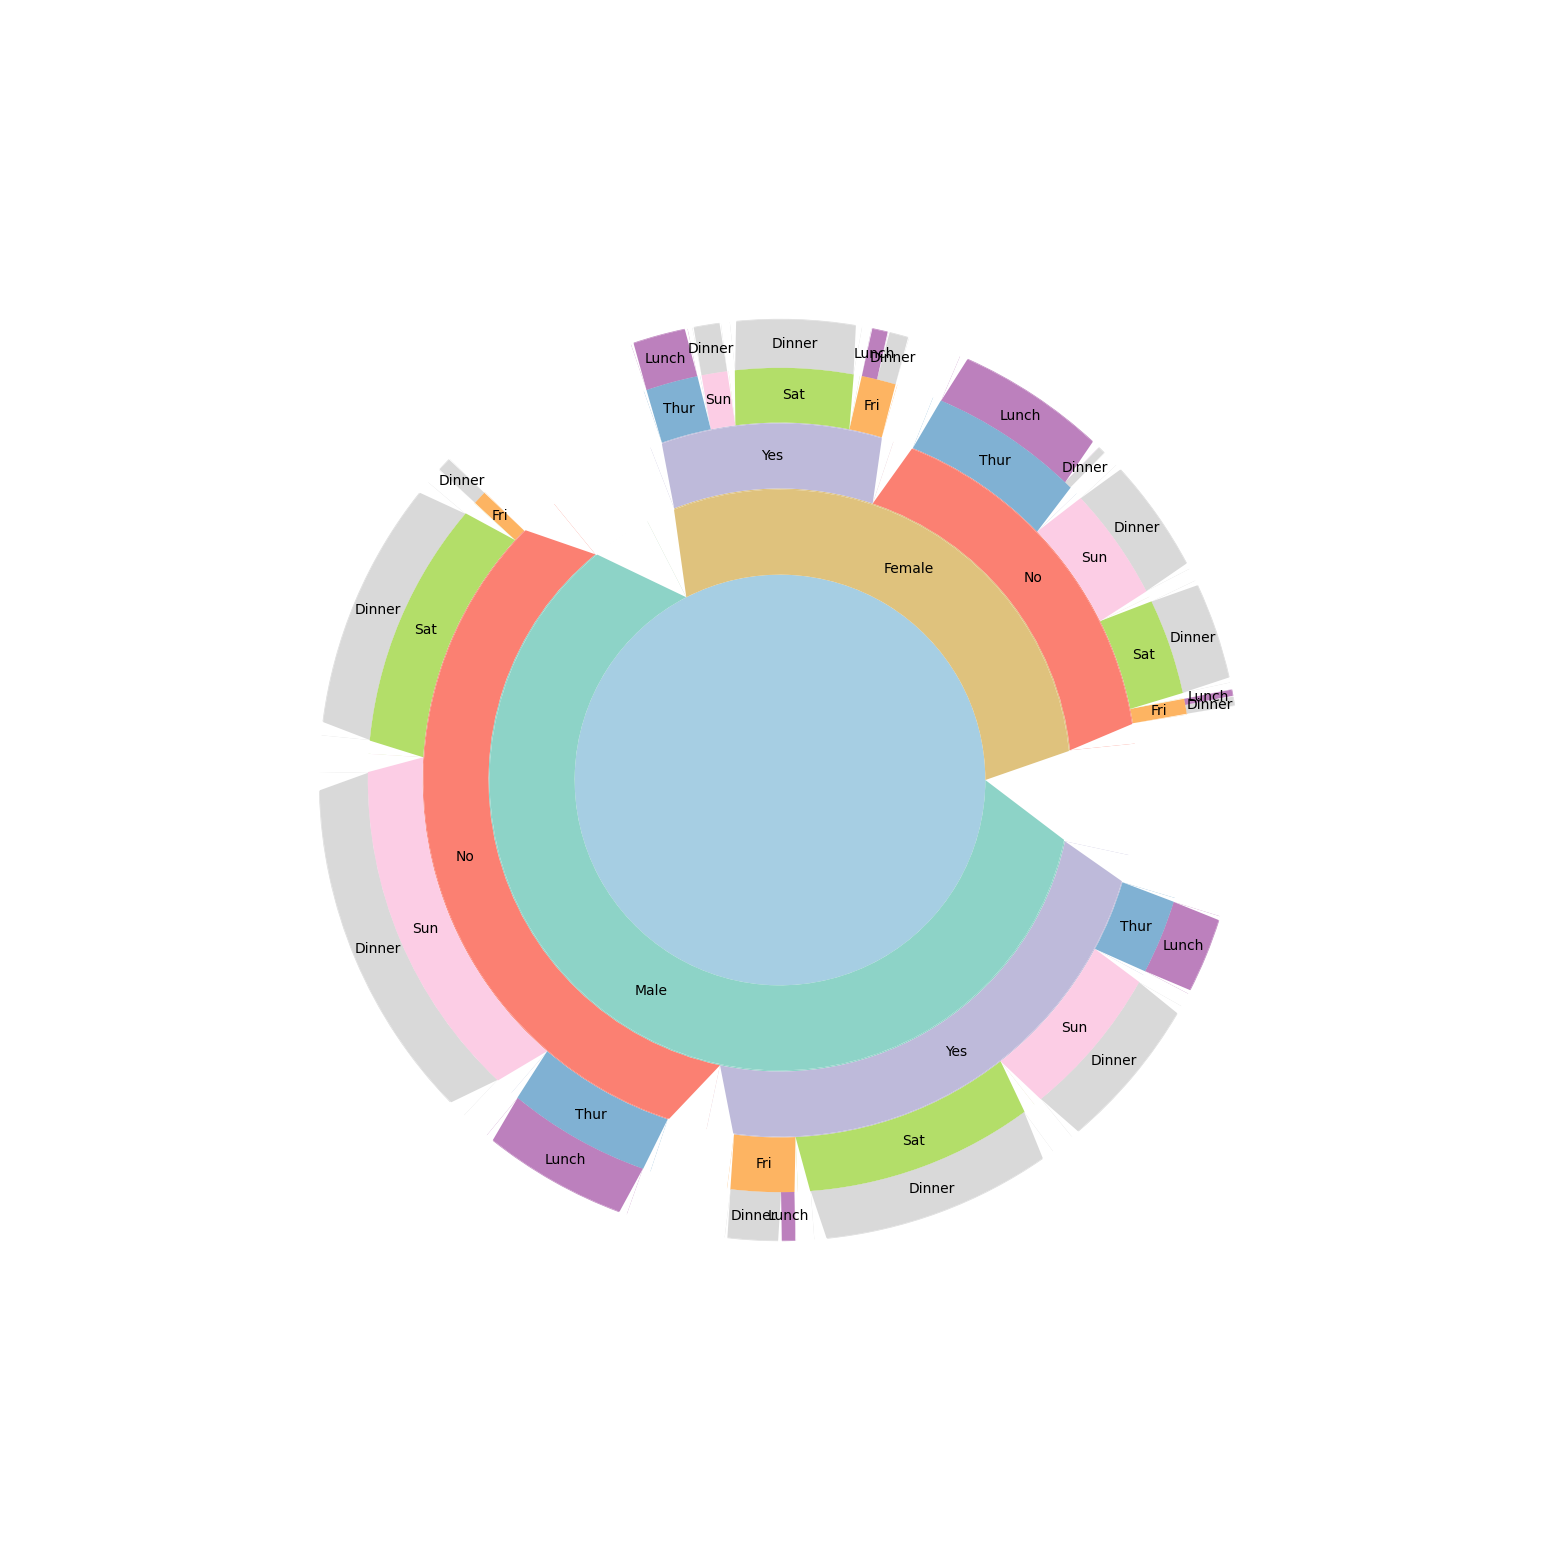

In [8]:
# canvas settings
fig, ax = plt.subplots(figsize=(20, 20), subplot_kw={"projection": "polar"})

ax.set_ylim(0, 15)
ax.set_frame_on(False)
ax.set_xticks([])
ax.set_yticks([])

global std_area
std_area = calculate_wedge_area(H0, R0)  # standard area is the area of root-ring

# First Layer
ax.bar([0], H0 + R0, width = c_all * c, color ='#a6cee3', edgecolor = "white", linewidth = 0, align = 'edge')
new_r = R0 + H0

# Second Layer
new_h = calculate_normalised_height(new_r, std_area)

c_2 = c_all
location_3_before = []
cut_len_3 = []
new_R_2 = new_r + new_h

for name in data_syn['rank_1'].drop_duplicates():
  data_1 = data_syn[data_syn['rank_1'] == name]
  drawing_data_2 = get_percentage_color_map(data_1, 'rank_2')
  length_2 = [i * c_2 for i in drawing_data_2['percentage']]
  location_2 = [0]
  pos = 0
  for i in range(len(length_2)-1):
    pos = pos + length_2[i]
    location_2.append(pos)

  # Draw curve first
  ax.bar(location_2, new_h, width = length_2, color = drawing_data_2['color'], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_r)

  # add labels
  alignment = 'center'
  for i in range(len(location_2)):
    # find label and position
    label = key2value(name_color_dict, drawing_data_2['color'][i])
    text_location = location_2[i] + length_2[i]/2
    # change size and font if needed
    ax.text(x = text_location, y = new_r + new_h/2, s = label, ha = alignment, va = 'center')

  bottom = new_R_2 - new_h
  for i in range(len(drawing_data_2)):
    # Cut left part
    cut_d = alfa * c_2 * drawing_data_2['percentage'][i]
    theta1, r1, length = remove_wedge_start(cut_d, location_2[i],bottom, new_R_2)
    ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

    # Add Top-up area
    topup_h = calculate_topup_height(alfa, cut_d/alfa, new_R_2, new_r)
    ax.bar(length, topup_h, width = cut_d/alfa*(1-AR), color = drawing_data_2['color'][i], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_2)

    location_3_before.append(length)
    topup_len = cut_d/alfa * (1-AR)
    cut_len_3.append(topup_len)

    # Cut right part
    if i == 0:
      cut_d = alfa * c_2 * drawing_data_2['percentage'][len(drawing_data_2['percentage'])-1]
    else:
      cut_d = alfa * c_2 * drawing_data_2['percentage'][i-1]

    theta1, r1 = remove_wedge_end(cut_d, location_2[i], bottom, new_R_2)
    ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

new_R_2 = new_R_2 + topup_h

# Third Layer(remove if do not use)
c_3 = c_2* (1-AR)
location_4_before = []
cut_len_4 = []
new_R_3 = 0
lst = [0,0]

for name_1 in data_syn['rank_1'].drop_duplicates():
  data_1 = data_syn[data_syn['rank_1'] == name_1]
  drawing_data_2 = get_percentage_color_map(data_1, 'rank_2')
  lst[1] = 0

  for name_2 in data_1['rank_2'].drop_duplicates():
    data_2 = data_1[data_1['rank_2'] == name_2]
    location_3 = []
    if len(data_2) > 0:
      drawing_data_3 = get_percentage_color_map(data_2, 'rank_3')
      length_3 = [i * cut_len_3[lst[1]] for i in drawing_data_3['percentage']]

      new_h = calculate_normalised_height(new_R_2, std_area)
      location_3 = [location_3_before[lst[1]]]
      pos = location_3_before[lst[1]]

      new_R_3 = new_R_2 + new_h
      for i in range(len(length_3)-1):
        pos = pos + length_3[i]
        location_3.append(pos)

      # Draw curve first
      ax.bar(location_3, new_h, width = length_3, color = drawing_data_3['color'], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_2)

      # add labels
      alignment = 'center'
      for i in range(len(location_3)):
        # find label and position
        label = key2value(name_color_dict, drawing_data_3['color'][i])
        text_location = location_3[i] + length_3[i]/2
        # change size and font if needed
        ax.text(x = text_location, y = new_R_2 + new_h/2, s = label, ha = alignment, va = 'center')

      bottom = new_R_2
      for i in range(len(drawing_data_3)):
        # Cut left part
        cut_d = alfa * c_3 * drawing_data_2['percentage'][lst[1]] * drawing_data_3['percentage'][i]
        theta1, r1, length = remove_wedge_start(cut_d, location_3[i], bottom, new_R_3)
        ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

        # Add Top-up area
        topup_h = calculate_topup_height(alfa, cut_d/alfa, new_R_3, new_R_2)
        ax.bar(length, topup_h, width = cut_d/alfa*(1-AR), color = drawing_data_3['color'][i], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_3)

        location_4_before.append(length)
        topup_len = cut_d/alfa * (1-AR)
        cut_len_4.append(topup_len)

        # Cut right part
        if i == 0:
          cut_d = alfa * c_3 * drawing_data_2['percentage'][lst[1]] * drawing_data_3['percentage'][len(drawing_data_3['percentage'])-1]
          theta1, r1 = remove_wedge_end(cut_d, location_3[i] + c_3 * drawing_data_2['percentage'][lst[1]], bottom, new_R_3)
        else:
          cut_d = alfa * c_3 * drawing_data_2['percentage'][lst[1]] *  drawing_data_3['percentage'][i-1]
          theta1, r1 = remove_wedge_end(cut_d, location_3[i], bottom, new_R_3)

        ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')
      lst[1] = lst[1] + 1

new_R_3 = new_R_3 + topup_h

# Fourth Layer(remove if do not use)
c_4 = c_3* (1-AR)
location_5_before = []
cut_len_5 = []
new_R_4 = 0
lst = [0,0,0,0]

for name_1 in data_syn['rank_1'].drop_duplicates():
  data_1 = data_syn[data_syn['rank_1'] == name_1]
  drawing_data_2 = get_percentage_color_map(data_1, 'rank_2')
  lst[0] = 0
  lst[1] = 0
  for name_2 in data_1['rank_2'].drop_duplicates():
    data_2 = data_1[data_1['rank_2'] == name_2]
    if len(data_2) > 0:
      data_2 = data_1[data_1['rank_2'] == name_2]
      drawing_data_3 = get_percentage_color_map(data_2, 'rank_3')
      lst[2] = 0
      for name_3 in data_2['rank_3'].drop_duplicates():
        data_3 = data_2[data_2['rank_3'] == name_3]
        location_4 = []
        if len(data_3) > 0:
          drawing_data_4 = get_percentage_color_map(data_3, 'rank_4')
          length_4 = [i * cut_len_4[lst[1]] for i in drawing_data_4['percentage']]

          # calcualte new height
          new_h = calculate_normalised_height(new_R_3, std_area)
          location_4 = [location_4_before[lst[1]]]
          pos = location_4_before[lst[1]]
          lst[1] = lst[1] + 1
          new_R_4 = new_R_3 + new_h
          for i in range(len(length_4)-1):
            pos = pos + length_4[i]
            location_4.append(pos)

          # Draw curve first
          ax.bar(location_4, new_h, width = length_4, color = drawing_data_4['color'], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_3)

          # add labels
          alignment = 'center'
          for i in range(len(location_4)):
            # find label and position
            label = key2value(name_color_dict, drawing_data_4['color'][i])
            text_location = location_4[i] + length_4[i]/2
            # change size and font if needed
            ax.text(x = text_location, y = new_R_3 + new_h/2, s = label, ha = alignment, va = 'center')

          bottom = new_R_3
          for i in range(len(drawing_data_4)):
            # Cut left part
            cut_d = alfa * c_4 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] * drawing_data_4['percentage'][i]
            theta1, r1, length = remove_wedge_start(cut_d, location_4[i], bottom, new_R_4)
            ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

            # Add Top-up area
            topup_h = calculate_topup_height(alfa, cut_d/alfa, new_R_4, new_R_3)
            ax.bar(length, topup_h, width = cut_d/alfa*(1-AR), color = drawing_data_4['color'][i], edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_4)

            location_5_before.append(length)
            topup_len = cut_d/alfa * (1-AR)
            cut_len_5.append(topup_len)

            # Cut right part
            if i == 0:
              cut_d = alfa * c_4 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] * drawing_data_4['percentage'][len(drawing_data_4['percentage'])-1]
              theta1, r1 = remove_wedge_end(cut_d, location_4[i] + c_4 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]], bottom, new_R_4)
            else:
              cut_d = alfa * c_4 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] *  drawing_data_4['percentage'][i-1]
              theta1, r1 = remove_wedge_end(cut_d, location_4[i], bottom, new_R_4)
            ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

        lst[2] = lst[2] + 1
      lst[0] = lst[0] + 1

# Fifth Layer
c_5 = c_4 * (1-AR)
location_6_before = []
cut_len_6 = []
new_R_5 = 0
lst = [0,0,0,0,0]

for name_1 in data_syn['rank_1'].drop_duplicates():
  data_1 = data_syn[data_syn['rank_1'] == name_1]
  drawing_data_2 = get_percentage_color_map(data_1, 'rank_2')
  lst[1] = 0
  lst[0] = 0

  for name_2 in data_1['rank_2'].drop_duplicates():
    data_2 = data_1[data_1['rank_2'] == name_2]
    drawing_data_3 = get_percentage_color_map(data_2, 'rank_3')
    lst[2] = 0

    for name_3 in data_2['rank_3'].drop_duplicates():
      data_3 = data_2[data_2['rank_3'] == name_3]
      drawing_data_4 = get_percentage_color_map(data_3, 'rank_4')
      lst[3] = 0

      for name_4 in data_3['rank_4'].drop_duplicates():
        data_4 = data_3[data_3['rank_4'] == name_4]
        location_5 = []
        drawing_data_5 = get_percentage_color_map(data_4, 'rank_5')
        length_5 = [i * cut_len_5[lst[1]] for i in drawing_data_5['percentage']]

        # Calculate new height
        new_h = calculate_normalised_height(new_R_4, std_area)
        location_5 = [location_5_before[lst[1]]]
        pos = location_5_before[lst[1]]
        lst[1] = lst[1] + 1
        new_R_5 = new_R_4 + new_h

        # Draw new curve
        for i in range(len(length_5)-1):
          pos = pos + length_5[i]
          location_5.append(pos)

        ax.bar(location_5, new_h, width=length_5, color=drawing_data_5['color'], edgecolor = "none", linewidth = 0, align = 'edge',bottom=new_R_4)

        # add labels
        alignment = 'center'
        for i in range(len(location_5)):
          # find label and position
          label = key2value(name_color_dict, drawing_data_5['color'][i])
          text_location = location_5[i] + length_5[i]/2
          # change size and font if needed
          ax.text(x = text_location, y = new_R_4 + new_h/2, s = label, ha = alignment, va = 'center')

        bottom = new_R_4
        for i in range(len(drawing_data_5)):
          # Cut left part
          cut_d = alfa * c_5 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] * drawing_data_4['percentage'][lst[3]] * drawing_data_5['percentage'][i]
          theta1, r1, length = remove_wedge_start(cut_d, location_5[i], bottom, new_R_5)
          ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

          # Add Top-up area
          topup_h = calculate_topup_height(alfa, cut_d/alfa, new_R_5, new_R_4)
          ax.bar(length, topup_h, width = cut_d/alfa*(1-AR), color = drawing_data_5['color'][i],  edgecolor = "none", linewidth = 0, align = 'edge', bottom = new_R_5)

          location_6_before.append(length)
          topup_len = cut_d/alfa * (1-AR)
          cut_len_6.append(topup_len)

          # Cut right part
          if i == 0:
            cut_d = alfa * c_5 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] * drawing_data_4['percentage'][lst[3]] * drawing_data_5['percentage'][len(drawing_data_5['percentage'])-1]
            theta1, r1 = remove_wedge_end(cut_d, location_5[i] + c_5 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]]* drawing_data_4['percentage'][lst[3]], bottom, new_R_5)
          else:
            cut_d = alfa * c_4 * drawing_data_2['percentage'][lst[0]] * drawing_data_3['percentage'][lst[2]] * drawing_data_4['percentage'][lst[3]] *  drawing_data_5['percentage'][i-1]
            theta1, r1 = remove_wedge_end(cut_d, location_5[i], bottom, new_R_5)
          ax.fill(theta1, r1, alpha=1, facecolor='white', edgecolor='none')

        lst[3] = lst[3] + 1
      lst[2] = lst[2] + 1
    lst[0] = lst[0] + 1

ax.bar([0], R0, width = c_all * c, color ='white', edgecolor = "white", linewidth = 0, align = 'edge')

**Add Legend if needed**

In [ ]:
name_replace = ['Male', 'Female', 'Smoker: Yes', 'Smoker: No', 'Thur', 'Fri', 'Sat', 'Sun', 'Dinner', 'Lunch']
handles = [plt.Rectangle((0, 0), 1, 1, color=color) for color in color4replace]
legend = ax.legend(handles=handles, labels=name_replace , loc='upper right', fontsize=12, shadow=True)